<a href="https://colab.research.google.com/github/Pki03/Stock_price_predictor/blob/main/fin3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Install Required Libraries**

In [61]:
!pip install numpy scipy scikit-learn keras tensorflow matplotlib pandas aylien_news_api nltk rpy2 textblob vaderSentiment yfinance requests plotly

# **Step 2: Import Libraries**

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso, LassoCV, ElasticNet
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import yfinance as yf
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# **Step 3: Download Stock Data Using yfinance**

In [137]:
# Example: Download data for Reliance Industries
stock_data = yf.download('RELIANCE.NS', start='2023-07-11', end='2024-07-15')
stock_data.to_csv('historical_prices.csv')


[*********************100%%**********************]  1 of 1 completed


In [138]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-11,2540.925781,2556.708984,2526.803955,2551.817139,2542.834717,10034674
2023-07-12,2553.293945,2586.245117,2549.001953,2554.632324,2545.639893,9366917
2023-07-13,2569.538818,2583.476074,2526.480957,2531.788086,2522.876221,7341467
2023-07-14,2538.249023,2548.309814,2515.266357,2529.665283,2520.760742,7562072
2023-07-17,2535.480225,2598.290283,2517.943115,2581.353271,2572.266846,11110020
...,...,...,...,...,...,...
2024-07-08,3178.000000,3217.600098,3165.050049,3201.800049,3201.800049,4750403
2024-07-09,3195.199951,3201.000000,3161.000000,3180.550049,3180.550049,3480001
2024-07-10,3190.000000,3195.000000,3126.300049,3168.449951,3168.449951,3567289


# **Step 4: Fetch Sentiment Data from GDELT API**

In [124]:
# Define the API endpoint
url = 'http://api.gdeltproject.org/api/v2/doc/doc'
params = {
    'query': 'Reliance Industries',
    'mode': 'ArtList',
    'maxrecords': '250',
    'format': 'json'
}

# Fetch the data from GDELT API
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    articles = data.get('articles', [])
    news_data = pd.DataFrame(articles)
    if not news_data.empty:
        # Extract the date from the 'seendate' or any appropriate field
        news_data['Date'] = pd.to_datetime(news_data['seendate']).dt.date
        analyzer = SentimentIntensityAnalyzer()
        def analyze_sentiment(text):
            return analyzer.polarity_scores(text)
        news_data['Sentiment'] = news_data['title'].apply(analyze_sentiment)
        sentiment_df = news_data['Sentiment'].apply(pd.Series)
        news_data = pd.concat([news_data, sentiment_df], axis=1)
        news_data.to_csv('sentiment_data.csv', index=False)
    else:
        print("No articles found.")
else:
    print(f"Failed to fetch data: {response.status_code}")


# **Step 5: Load and Merge Data**

In [125]:
# Load historical stock prices
prices_df = pd.read_csv('historical_prices.csv', parse_dates=['Date'])
prices_df.set_index('Date', inplace=True)

# Load sentiment data
sentiment_df = pd.read_csv('sentiment_data.csv', parse_dates=['Date'])
sentiment_df.set_index('Date', inplace=True)

# Merge data on date
data = prices_df.merge(sentiment_df, how='inner', left_index=True, right_index=True)


# **Step 6: Feature Scaling**

In [126]:
# Ensure you only select numeric columns for scaling
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_columns]

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(numeric_data)

# Prepare the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


# **Step 7: Prepare Data for Random Forest and Lasso**

In [127]:
# Prepare features and target for Random Forest
X_rf = numeric_data.drop(columns=['Close'])
y_rf = numeric_data['Close']

# Train-test split
train_size = int(len(numeric_data) * 0.8)
X_rf_train, X_rf_test = X_rf[:train_size], X_rf[train_size:]
y_rf_train, y_rf_test = y_rf[:train_size], y_rf[train_size:]


# **Step 8: Train and Evaluate Cross-Validated Lasso Model**

In [128]:
from sklearn.linear_model import LassoCV

# Define the model with cross-validated Lasso
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5)

# Fit the model
lasso_cv_model.fit(X_rf_train, y_rf_train)

# Predicting
lasso_cv_train_predict = lasso_cv_model.predict(X_rf_train)
lasso_cv_test_predict = lasso_cv_model.predict(X_rf_test)

# Calculate RMSE
lasso_cv_train_rmse = np.sqrt(mean_squared_error(y_rf_train, lasso_cv_train_predict))
lasso_cv_test_rmse = np.sqrt(mean_squared_error(y_rf_test, lasso_cv_test_predict))
lasso_cv_train_mae = mean_absolute_error(y_rf_train, lasso_cv_train_predict)
lasso_cv_test_mae = mean_absolute_error(y_rf_test, lasso_cv_test_predict)
lasso_cv_train_r2 = r2_score(y_rf_train, lasso_cv_train_predict)
lasso_cv_test_r2 = r2_score(y_rf_test, lasso_cv_test_predict)
print(f'Cross-Validated Lasso Train RMSE: {lasso_cv_train_rmse}')
print(f'Cross-Validated Lasso Test RMSE: {lasso_cv_test_rmse}')
print(f'Cross-Validated Lasso Train MAE: {lasso_cv_train_mae}')
print(f'Cross-Validated Lasso Test MAE: {lasso_cv_test_mae}')
print(f'Cross-Validated Lasso Train R²: {lasso_cv_train_r2}')
print(f'Cross-Validated Lasso Test R²: {lasso_cv_test_r2}')


Cross-Validated Lasso Train RMSE: 0.004705233561710395
Cross-Validated Lasso Test RMSE: 0.007186074785311851
Cross-Validated Lasso Train MAE: 0.003567897928656224
Cross-Validated Lasso Test MAE: 0.006283782598893594
Cross-Validated Lasso Train R²: 0.9999999945535217
Cross-Validated Lasso Test R²: 0.9999999299638582


# **Step 9: Plot**

In [129]:
import plotly.graph_objects as go
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming data, X_rf, y_rf, X_rf_train, X_rf_test, y_rf_train, and y_rf_test are already defined as before

# Define the model with cross-validated Lasso
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5)

# Fit the model
lasso_cv_model.fit(X_rf_train, y_rf_train)

# Predicting
lasso_cv_train_predict = lasso_cv_model.predict(X_rf_train)
lasso_cv_test_predict = lasso_cv_model.predict(X_rf_test)

# Calculate RMSE
lasso_cv_train_rmse = np.sqrt(mean_squared_error(y_rf_train, lasso_cv_train_predict))
lasso_cv_test_rmse = np.sqrt(mean_squared_error(y_rf_test, lasso_cv_test_predict))
print(f'Cross-Validated Lasso Train RMSE: {lasso_cv_train_rmse}')
print(f'Cross-Validated Lasso Test RMSE: {lasso_cv_test_rmse}')

# Cross-validation scores
cv_scores = cross_val_score(lasso_cv_model, X_rf, y_rf, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean Cross-Validation RMSE: {cv_rmse_scores.mean()}')

# Plotting with Plotly
fig = go.Figure()

# Add training actual vs predicted
fig.add_trace(go.Scatter(x=y_rf_train.index, y=y_rf_train, mode='lines', name='Actual Train', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=y_rf_train.index, y=lasso_cv_train_predict, mode='lines', name='Predicted Train', line=dict(color='red', dash='dash')))

# Add test actual vs predicted
fig.add_trace(go.Scatter(x=y_rf_test.index, y=y_rf_test, mode='lines', name='Actual Test', line=dict(color='green')))
fig.add_trace(go.Scatter(x=y_rf_test.index, y=lasso_cv_test_predict, mode='lines', name='Predicted Test', line=dict(color='orange', dash='dash')))

# Update layout
fig.update_layout(
    title='Actual vs Predicted Close Prices',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend=dict(x=0, y=1, traceorder='normal'),
    height=600,
    width=1000
)

# Show plot
fig.show()

# Prepare the input data for the next day prediction
last_known_data = X_rf.iloc[-1].values.reshape(1, -1)

# Predict the next day's price
next_day_prediction = lasso_cv_model.predict(last_known_data)

# Print the predicted price for the next day
print(f'Predicted Close Price for the next day: {next_day_prediction[0]}')


Cross-Validated Lasso Train RMSE: 0.004705233561710395
Cross-Validated Lasso Test RMSE: 0.007186074785311851
Cross-Validation RMSE Scores: [0.01591838 0.00471156 0.006366   0.13449359 0.00634814]
Mean Cross-Validation RMSE: 0.03356753365610564


Predicted Close Price for the next day: 3180.541068731507


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LassoCV was fitted with feature names



# **Step 10: Predict the Next Day's Price**

In [130]:
# Prepare the input data for the next day prediction
last_known_data = X_rf.iloc[-1].values.reshape(1, -1)

# Predict the next day's price
next_day_prediction = lasso_cv_model.predict(last_known_data)

# Print the predicted price for the next day
print(f'Predicted Close Price for the next day: {next_day_prediction[0]}')


Predicted Close Price for the next day: 3180.541068731507


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LassoCV was fitted with feature names



# **Other Models Tried**

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-4, 0, 50)
}

# Define the model
lasso = Lasso()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_rf_train, y_rf_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predicting with the best model
train_predict = best_model.predict(X_rf_train)
test_predict = best_model.predict(X_rf_test)

# Calculate RMSE for the best model
train_rmse = np.sqrt(mean_squared_error(y_rf_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_rf_test, test_predict))
print(f'Best Lasso Train RMSE: {train_rmse}')
print(f'Best Lasso Test RMSE: {test_rmse}')
print(f'Best Lasso Parameters: {best_params}')

# Cross-validation scores with the best model
cv_scores = cross_val_score(best_model, X_rf, y_rf, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Best Model Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean Cross-Validation RMSE: {cv_rmse_scores.mean()}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Best Lasso Train RMSE: 0.01054170122701785
Best Lasso Test RMSE: 0.0046423186086651325
Best Lasso Parameters: {'alpha': 0.18420699693267145}
Best Model Cross-Validation RMSE Scores: [0.1409513  0.07309459 0.06906372 0.4766918  0.00792026]
Mean Cross-Validation RMSE: 0.15354433229976877


In [55]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

# Define the model
lasso = Lasso(alpha=0.01)

# Define RFE with the model
rfe = RFE(estimator=lasso, n_features_to_select=10)

# Fit RFE
rfe.fit(X_rf_train, y_rf_train)

# Transform the data
X_rf_train_rfe = rfe.transform(X_rf_train)
X_rf_test_rfe = rfe.transform(X_rf_test)

# Fit the model with selected features
lasso.fit(X_rf_train_rfe, y_rf_train)

# Predicting
train_predict_rfe = lasso.predict(X_rf_train_rfe)
test_predict_rfe = lasso.predict(X_rf_test_rfe)

# Calculate RMSE for the model with selected features
train_rmse_rfe = np.sqrt(mean_squared_error(y_rf_train, train_predict_rfe))
test_rmse_rfe = np.sqrt(mean_squared_error(y_rf_test, test_predict_rfe))
print(f'Lasso with RFE Train RMSE: {train_rmse_rfe}')
print(f'Lasso with RFE Test RMSE: {test_rmse_rfe}')


Lasso with RFE Train RMSE: 0.02835834556568483
Lasso with RFE Test RMSE: 0.05832956639426275


In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso

# Define the parameter distribution
param_dist = {
    'alpha': np.logspace(-4, 0, 100)
}

# Define the model
lasso = Lasso()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=lasso, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
random_search.fit(X_rf_train, y_rf_train)

# Get the best parameters and the best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Predicting with the best model
train_predict_random = best_model_random.predict(X_rf_train)
test_predict_random = best_model_random.predict(X_rf_test)

# Calculate RMSE for the best model
train_rmse_random = np.sqrt(mean_squared_error(y_rf_train, train_predict_random))
test_rmse_random = np.sqrt(mean_squared_error(y_rf_test, test_predict_random))
print(f'Best Randomized Lasso Train RMSE: {train_rmse_random}')
print(f'Best Randomized Lasso Test RMSE: {test_rmse_random}')
print(f'Best Randomized Lasso Parameters: {best_params_random}')

# Cross-validation scores with the best model
cv_scores_random = cross_val_score(best_model_random, X_rf, y_rf, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_random = np.sqrt(-cv_scores_random)
print(f'Best Randomized Model Cross-Validation RMSE Scores: {cv_rmse_scores_random}')
print(f'Mean Cross-Validation RMSE: {cv_rmse_scores_random.mean()}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Randomized Lasso Train RMSE: 0.006490682959976583
Best Randomized Lasso Test RMSE: 0.007701138897556435
Best Randomized Lasso Parameters: {'alpha': 0.20565123083486536}
Best Randomized Model Cross-Validation RMSE Scores: [0.13773482 0.07028626 0.06655826 0.45166577 0.00256002]
Mean Cross-Validation RMSE: 0.14576102536197005


In [57]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'alpha': np.logspace(-4, 0, 100),
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]  # Mixing parameter for ElasticNet
}

# Define the model
elastic_net = ElasticNet()

# Perform randomized search with cross-validation
random_search_en = RandomizedSearchCV(estimator=elastic_net, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
random_search_en.fit(X_rf_train, y_rf_train)

# Get the best parameters and the best model
best_params_en = random_search_en.best_params_
best_model_en = random_search_en.best_estimator_

# Predicting with the best model
train_predict_en = best_model_en.predict(X_rf_train)
test_predict_en = best_model_en.predict(X_rf_test)

# Calculate RMSE for the best model
train_rmse_en = np.sqrt(mean_squared_error(y_rf_train, train_predict_en))
test_rmse_en = np.sqrt(mean_squared_error(y_rf_test, test_predict_en))
print(f'Best Elastic Net Train RMSE: {train_rmse_en}')
print(f'Best Elastic Net Test RMSE: {test_rmse_en}')
print(f'Best Elastic Net Parameters: {best_params_en}')

# Cross-validation scores with the best model
cv_scores_en = cross_val_score(best_model_en, X_rf, y_rf, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_en = np.sqrt(-cv_scores_en)
print(f'Best Elastic Net Cross-Validation RMSE Scores: {cv_rmse_scores_en}')
print(f'Mean Cross-Validation RMSE: {cv_rmse_scores_en.mean()}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Elastic Net Train RMSE: 6.423927999417644e-05
Best Elastic Net Test RMSE: 0.0001277617811756275
Best Elastic Net Parameters: {'l1_ratio': 0.1, 'alpha': 0.00010974987654930556}
Best Elastic Net Cross-Validation RMSE Scores: [0.00468178 0.0023596  0.00294712 0.22550815 0.00025078]
Mean Cross-Validation RMSE: 0.04714948597073309


In [58]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

# Apply robust scaling to handle outliers
scaler = RobustScaler()
X_rf_scaled = scaler.fit_transform(X_rf)

# Train-test split with scaled data
X_rf_train_scaled, X_rf_test_scaled = X_rf_scaled[:train_size], X_rf_scaled[train_size:]

# Define the parameter distribution for Elastic Net
param_dist = {
    'alpha': np.logspace(-4, 0, 100),
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]  # Mixing parameter for ElasticNet
}

# Define the Elastic Net model
elastic_net = ElasticNet()

# Perform randomized search with cross-validation
random_search_en = RandomizedSearchCV(estimator=elastic_net, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
random_search_en.fit(X_rf_train_scaled, y_rf_train)

# Get the best parameters and the best model
best_params_en = random_search_en.best_params_
best_model_en = random_search_en.best_estimator_

# Predicting with the best model
train_predict_en = best_model_en.predict(X_rf_train_scaled)
test_predict_en = best_model_en.predict(X_rf_test_scaled)

# Calculate RMSE for the best model
train_rmse_en = np.sqrt(mean_squared_error(y_rf_train, train_predict_en))
test_rmse_en = np.sqrt(mean_squared_error(y_rf_test, test_predict_en))
print(f'Best Elastic Net Train RMSE: {train_rmse_en}')
print(f'Best Elastic Net Test RMSE: {test_rmse_en}')
print(f'Best Elastic Net Parameters: {best_params_en}')

# Cross-validation scores with the best model
cv_scores_en = cross_val_score(best_model_en, X_rf_scaled, y_rf, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_en = np.sqrt(-cv_scores_en)
print(f'Best Elastic Net Cross-Validation RMSE Scores: {cv_rmse_scores_en}')
print(f'Mean Cross-Validation RMSE: {cv_rmse_scores_en.mean()}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Elastic Net Train RMSE: 0.01054788019717271
Best Elastic Net Test RMSE: 0.006940254077723218
Best Elastic Net Parameters: {'l1_ratio': 1, 'alpha': 0.002595024211399737}
Best Elastic Net Cross-Validation RMSE Scores: [0.1357207  0.08937876 0.08208656 0.65526433 0.0056134 ]
Mean Cross-Validation RMSE: 0.19361275172998227


# **LSTM Model**

[*********************100%%**********************]  1 of 1 completed


X_train shape: (148, 60)
X_test shape: (37, 60)
y_train shape: (148,)
y_test shape: (37,)
Epoch 1/25
5/5 [==============================] - 5s 80ms/step - loss: 0.1500
Epoch 2/25
5/5 [==============================] - 0s 82ms/step - loss: 0.0267
Epoch 3/25
5/5 [==============================] - 0s 82ms/step - loss: 0.0128
Epoch 4/25
5/5 [==============================] - 0s 85ms/step - loss: 0.0155
Epoch 5/25
5/5 [==============================] - 0s 85ms/step - loss: 0.0108
Epoch 6/25
5/5 [==============================] - 0s 90ms/step - loss: 0.0069
Epoch 7/25
5/5 [==============================] - 0s 49ms/step - loss: 0.0074
Epoch 8/25
5/5 [==============================] - 0s 48ms/step - loss: 0.0050
Epoch 9/25
5/5 [==============================] - 0s 48ms/step - loss: 0.0055
Epoch 10/25
5/5 [==============================] - 0s 54ms/step - loss: 0.0046
Epoch 11/25
5/5 [==============================] - 0s 51ms/step - loss: 0.0044
Epoch 12/25
5/5 [==============================] -

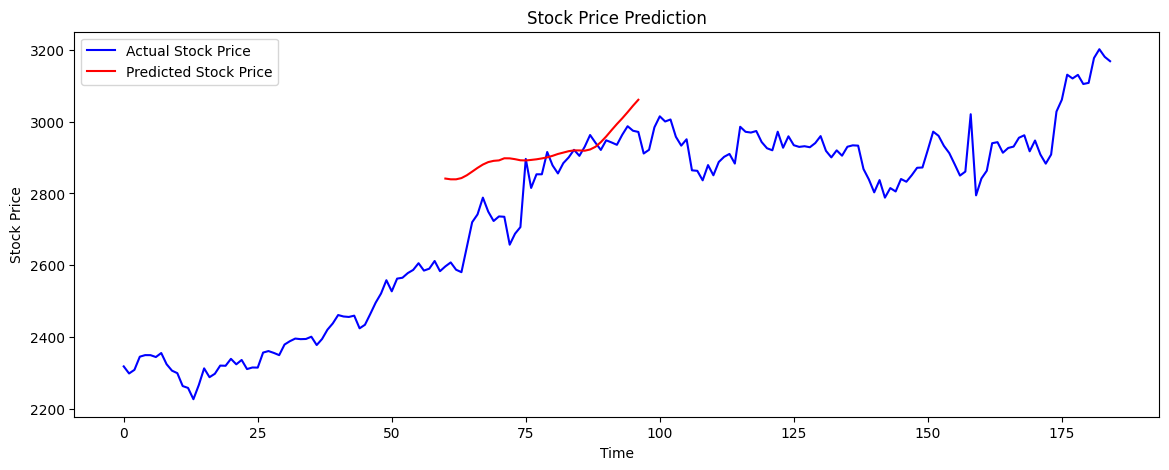

1/1 [==============================] - 0s 25ms/step
Predicted Close Price for the next day: 3075.5595703125
1/1 [==============================] - 0s 27ms/step
Predicted Close Prices for the next week: [3075.5596 3084.3003 3088.919  3090.4238 3089.6204 3087.144  3083.482 ]


In [136]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Load historical stock prices
stock_data = yf.download('RELIANCE.NS', start='2023-07-11', end='2024-07-11')
stock_data.to_csv('historical_prices.csv')

# Prepare the data
data = stock_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Ensure we have sufficient data points
if X_train.size == 0 or X_test.size == 0:
    raise ValueError("Training or testing data is empty. Please check the data and sequence length.")

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)

# Make predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(data[seq_length:], color='blue', label='Actual Stock Price')
plt.plot(range(seq_length, seq_length + len(predicted_stock_price)), predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Predicting the next day
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape(1, seq_length, 1)
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f'Predicted Close Price for the next day: {next_day_prediction[0, 0]}')

# Predicting the next week (7 days)
predictions = []
current_sequence = last_sequence
for _ in range(7):
    next_pred = model.predict(current_sequence)
    predictions.append(next_pred[0, 0])
    current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(next_pred, (1, 1, 1)), axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print(f'Predicted Close Prices for the next week: {predictions.flatten()}')


In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for training data
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)
y_train_scaled = scaler.inverse_transform(y_train.reshape(-1, 1))

train_mae = mean_absolute_error(y_train_scaled, train_predictions)
train_mse = mean_squared_error(y_train_scaled, train_predictions)
train_r2 = r2_score(y_train_scaled, train_predictions)

print(f'Training MAE: {train_mae}')
print(f'Training MSE: {train_mse}')
print(f'Training R²: {train_r2}')

# Calculate metrics for testing data
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

test_mae = mean_absolute_error(y_test_scaled, test_predictions)
test_mse = mean_squared_error(y_test_scaled, test_predictions)
test_r2 = r2_score(y_test_scaled, test_predictions)

print(f'Testing MAE: {test_mae}')
print(f'Testing MSE: {test_mse}')
print(f'Testing R²: {test_r2}')


5/5 [==============================] - 0s 22ms/step
Training MAE: 40.82401914854307
Training MSE: 2777.8853730692254
Training R²: 0.9569045282036689
2/2 [==============================] - 0s 18ms/step
Testing MAE: 78.60676863386824
Testing MSE: 9345.799793995715
Testing R²: 0.23372958384582676
